In [1]:
import vtk
import matplotlib.pyplot as plt
import numpy as np
import os
from vtk import vtkUnstructuredGridReader
from vtk import vtkXMLUnstructuredGridReader
from vtk.util import numpy_support as VN
from vtk.util.numpy_support import vtk_to_numpy
from scipy.spatial import KDTree
from scipy.interpolate import RegularGridInterpolator
from scipy.signal import savgol_filter
import pygmt
import parallel_curves
import importlib
import perplex_dehydration
importlib.reload(perplex_dehydration)
import matplotlib.patches as patches

In [2]:
def depth_average_porosity(base_x, bin_sizes, X_POR, Z_POR, POROSITY):
    '''
    base_x = the initial value to start binning the data (double)
    bin_sizes = an array of doubles that specifies the width of the bins. The first bin will start
                at base_x, and the subsequent bins will be shifted by the size of the previous bins.
    X_POR  = uniform mesh that specifies the x-values of the grid
    Z_POR  = uniform mesh that specifies the z-values of the grid
    POROSITY = uniform mesh that specifies the porosity values on the grid

    Returns:
    An array (object) that contains the depth averaged porosity within each bin, and an array that
    specifies the depths of the depth averaging.
    '''
    # Create an array to store the depth averages. There must be the same
    # number of depth averaged curves as there are the number of bins.
    depth_averaged_por = np.zeros(len(bin_sizes), dtype=object)
    z_vals_for_bins = np.unique(Z_POR.flatten())
    
    for i in range(len(bin_sizes)):
        average_por_at_z_vals = np.zeros(len(z_vals_for_bins))
        for j in range(len(z_vals_for_bins)):
    
            por_indices = np.where( (X_POR.flatten() >= base_x) & (X_POR.flatten() <= base_x + bin_sizes[i]) & (Z_POR.flatten() == z_vals_for_bins[j]) )
            por_at_current_z = POROSITY.flatten()[por_indices]
            average_por_at_z_vals[j] = np.average(por_at_current_z)
    
        depth_averaged_por[i] = average_por_at_z_vals
        base_x += bin_sizes[i]

    return z_vals_for_bins, depth_averaged_por

# LOAD IN THE ASPECT OUTPUT <br>
### This assumes a lithostatic pressure, and uses the WorldBuilder to Initialize the Slab Temperature. The grid spacing is 250 m.

In [3]:
base_path = "/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/ASPECT_output/"
file_path = "test-lithostatic-P-CAM/solution/solution-00000.0000.vtu"
reader = vtkXMLUnstructuredGridReader()
reader.SetFileName(base_path + file_path)
reader.Update()
data = reader.GetOutput()
points = data.GetPoints()

x                = vtk_to_numpy(points.GetData())
T_raw            = vtk_to_numpy(data.GetPointData().GetArray("T"))
P_raw            = vtk_to_numpy(data.GetPointData().GetArray("p"))
subducting_litho = vtk_to_numpy(data.GetPointData().GetArray("Subducting_Perid"))
subducting_gabbr = vtk_to_numpy(data.GetPointData().GetArray("Subducting_Gabbro"))
subducting_crust = vtk_to_numpy(data.GetPointData().GetArray("Subducting_Crust"))
depth_raw        = vtk_to_numpy(data.GetPointData().GetArray("depth"))

slab_inds = np.where( (subducting_litho >= 0.9) | (subducting_crust >= 0.9) | (subducting_gabbr >= 0.9))
T_slab = T_raw[slab_inds]
P_slab = P_raw[slab_inds]
depth_slab = depth_raw[slab_inds]
x_slab = x[slab_inds]

slabKDTree = KDTree(np.c_[x_slab[:, 0], np.max(x_slab[:, 1]) - x_slab[:, 1]])
totalKDTree = KDTree(np.c_[x[:, 0], np.max(x[:, 1]) - x[:, 1]])

# Interpolate the pressure onto a uniform mesh. This is required to calculate the gradient in the pressure within the slab, which is needed for the darcy velocity.

In [4]:
dx = 250
dy = 250

x_array = np.arange(np.min(x[:, 0]), np.max(x[:, 0]) + dx, dx)
y_array = np.arange(np.min(x[:, 1]), np.max(x[:, 1]) + dy, dy)

X_uniform, Y_uniform = np.meshgrid(x_array, y_array, indexing="ij")
P_mesh = np.zeros(len(np.ravel(X_uniform)))

for i in range(len(np.ravel(X_uniform))):
    x_value = np.ravel(X_uniform)[i]
    y_value = np.ravel(Y_uniform)[i]

    dd, ii = totalKDTree.query([x_value, y_value], k=1)
    P_mesh[i] = P_raw[ii]

P_mesh = P_mesh.reshape(np.shape(X_uniform))

# Create a KDTree for the uniform mesh, so that we can determine the pressure 
# gradient at each point on the parallel slab profiles
uniform_KDTree = KDTree(np.c_[np.ravel(X_uniform), np.ravel(Y_uniform)])
# Calculate the gradient
dPdx, dPdy = np.gradient(P_mesh, dx, dy)

# Use the file used to define the slab structure in worldbuilder for the location of the slab surface

In [5]:
slab_top_y = np.abs(np.loadtxt(fname="slab_top_profile.txt", usecols=2)) * 1e3 # km --> m
cutoff_depth = 200e3 # only points above 200 km
slab_top_y = slab_top_y[slab_top_y <= cutoff_depth]
trench_x = 200e3 # model trench is at x=200 km
slab_top_y -= np.min(slab_top_y) # make sure that the slab top is at a depth of 0 m
slab_top_x = np.zeros(len(slab_top_y))
for i in range(len(slab_top_y)):
    slab_top_x[i] = i * 1e3 + trench_x # file spacing is 1 km

# Interpolate slab top to finer spacing using a cubic spline
from scipy.interpolate import CubicSpline
cs = CubicSpline(slab_top_x, slab_top_y, bc_type='natural')  # 'natural' enforces zero second derivative at boundaries
dx = 250
slab_top_x = np.arange(np.min(slab_top_x), np.max(slab_top_x) + dx, dx)
slab_top_y = cs(slab_top_x)

# Create arrays which store the position, Pressure, Temperature, and Pressure gradients along profiles parallel to the slab surface

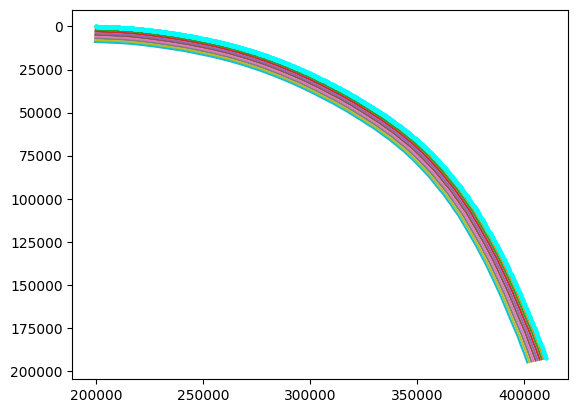

In [6]:
# Create the parallel lines to the interpolated slab surface.
# We consider a 9 km thick area of hydration, with a line spacing
# of 50 m.
base_depth = 0
hydrated_thickness = 9.0e3
line_spacing = 0.05e3
number_of_lines = int(hydrated_thickness / line_spacing) + 1

# For computing the solid velocity at each point within the slab
s2yr = 60 * 60 * 24 * 365.25
convergence_rate = 0.085 # m/yr

# Create storage for the x and y coordinates of the parallel profiles
parallel_slab_x = np.zeros(number_of_lines, dtype=object)
parallel_slab_y = np.zeros(number_of_lines, dtype=object)

# Create storage for the P and T along the parallel profiles
parallel_slab_T = np.zeros(number_of_lines, dtype=object)
parallel_slab_p = np.zeros(number_of_lines, dtype=object)

# Create storage for the Px and Py pressure gradients on the parallel profiles
parallel_slab_Px = np.zeros(number_of_lines, dtype=object)
parallel_slab_Py = np.zeros(number_of_lines, dtype=object)

# Draw parallel lines to the slab top curve, fill the above storage arrays (except the solid velocity)
for i in range(number_of_lines):
    res = parallel_curves.parallel_curves(slab_top_x, slab_top_y, d=base_depth + line_spacing * (i), make_plot=False, flag1=False)
    parallel_slab_x[i] = res["x_inner"]
    parallel_slab_y[i] = res["y_inner"]
    parallel_slab_T[i] = np.zeros(len(parallel_slab_x[i]))
    parallel_slab_p[i] = np.zeros(len(parallel_slab_x[i]))
    parallel_slab_Px[i] = np.zeros(len(parallel_slab_x[i]))
    parallel_slab_Py[i] = np.zeros(len(parallel_slab_x[i]))
    for j in range(len(parallel_slab_x[i])):
        dd, ii = slabKDTree.query([parallel_slab_x[i][j], parallel_slab_y[i][j]], k=1)
        parallel_slab_T[i][j] = T_slab[ii]
        parallel_slab_p[i][j] = P_slab[ii]

        dd, ii = uniform_KDTree.query([parallel_slab_x[i][j], parallel_slab_y[i][j]], k=1)
        parallel_slab_Px[i][j] = np.ravel(dPdx)[ii]
        parallel_slab_Py[i][j] = np.ravel(dPdy)[ii]
        
    if i%20==0:
        plt.plot(parallel_slab_x[i], parallel_slab_y[i])
        
plt.scatter(slab_top_x, slab_top_y, c='cyan', s=5, zorder=1000000)
plt.gca().invert_yaxis()
plt.show()

# I have the cross section from ASPECT. I have created slab surface parallel profiles which contain: slab pressure, slab temperature, x/y components of the solid velocity, x/y components of the pressure gradients. This means that all we need is the permeability distribution and we can calculate the fluid velocity using Darcy's law:

\begin{equation}
    \vec{u}_f = \vec{u}_s - \frac{k}{\eta_f} \vec{\nabla}P
\end{equation}

All that is left is to define the input hydration, and the input permeability. I think initially it would be best to just assume that this distribution does NOT change, and then deal with properly varying the permeability if need be. 

Start by defining a constant value of permeability along each parallel slab profile. This will allow us to instantly determine what the fluid velocity is at each point in our model.

In [7]:
eta_f = 1e-3
P_0 = 100 # MPa
solid_density = 3000 # kg/m3
dz = 50
depth_vals = np.arange(0, 9.0e3 + dz, dz) # m

perm_depths = np.array([1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) # m
perms = np.array([1e-11, 1e-13, 5e-14, 1e-15, 5e-16, 1e-16, 2e-17, 1e-17, 1e-17, 1e-17, 8e-18, 6e-18, 5e-18])

hatakeyama_gamma = 2.9e-2
hatakeyama_k     = 2.3e-21

hatakeyama_high_gamma = 2.7e-2
hatakeyama_high_k     = 6.1e-20

log_kr = -19
log_ks = -12
alpha  = 1.8

importlib.reload(perplex_dehydration)

permeability_inputs_ha = perplex_dehydration.my_permeability(depth_vals, perm_depths, perms, 
                                                             P_0, hatakeyama_high_k, hatakeyama_high_gamma, 
                                                             solid_density)

permeability_inputs_ha_no_lim = perplex_dehydration.my_permeability(depth_vals, perm_depths, perms, 
                                                                    P_0, hatakeyama_high_k, hatakeyama_high_gamma, 
                                                                    solid_density)

permeability_inputs_inf = np.zeros(len(permeability_inputs_ha)) + 1e50


volume_conversion = dx * line_spacing * 1 # m3
    
ha_parallel_v_fx = np.zeros(len(parallel_slab_x), dtype=object)
ha_parallel_v_fy = np.zeros(len(parallel_slab_x), dtype=object)

ha_no_lim_parallel_v_fx = np.zeros(len(parallel_slab_x), dtype=object)
ha_no_lim_parallel_v_fy = np.zeros(len(parallel_slab_x), dtype=object)

inf_parallel_v_fx = np.zeros(len(parallel_slab_x), dtype=object)
inf_parallel_v_fy = np.zeros(len(parallel_slab_x), dtype=object)

for i in range(len(ha_parallel_v_fy)):
    ha_parallel_v_fx[i] = np.zeros(len(parallel_slab_x[i]))
    ha_parallel_v_fy[i] = np.zeros(len(parallel_slab_x[i]))

    ha_no_lim_parallel_v_fx[i] = np.zeros(len(parallel_slab_x[i]))
    ha_no_lim_parallel_v_fy[i] = np.zeros(len(parallel_slab_x[i]))
    
    inf_parallel_v_fx[i] = np.zeros(len(parallel_slab_x[i]))
    inf_parallel_v_fy[i] = np.zeros(len(parallel_slab_x[i]))
    
    for j in range(len(ha_parallel_v_fx[i])):
        ha_parallel_v_fx[i][j] = -(permeability_inputs_ha[i] / eta_f * parallel_slab_Px[i][j])
        ha_parallel_v_fy[i][j] = -(permeability_inputs_ha[i] / eta_f * parallel_slab_Py[i][j])

        ha_no_lim_parallel_v_fx[i][j] = -(permeability_inputs_ha[i] / eta_f * parallel_slab_Px[i][j])
        ha_no_lim_parallel_v_fy[i][j] = -(permeability_inputs_ha[i] / eta_f * parallel_slab_Py[i][j])
        
        inf_parallel_v_fx[i][j] = -(permeability_inputs_inf[i] / eta_f * parallel_slab_Px[i][j])
        inf_parallel_v_fy[i][j] = -(permeability_inputs_inf[i] / eta_f * parallel_slab_Py[i][j])

# CONVERT THE FLUID VELOCITY FROM M/S TO M/YR
ha_parallel_v_fx *= s2yr
ha_parallel_v_fy *= s2yr

ha_no_lim_parallel_v_fx *= s2yr
ha_no_lim_parallel_v_fy *= s2yr

inf_parallel_v_fx *= s2yr
inf_parallel_v_fy *= s2yr

minimum_v_fy     = -0.01 # 0.5 cm/yr minimum fluid velocity, negatitve corresponds to upward motion
for i in range(len(ha_parallel_v_fy)):
    inf_parallel_v_fy[i][inf_parallel_v_fy[i] > minimum_v_fy] = minimum_v_fy
    ha_parallel_v_fy[i][ha_parallel_v_fy[i] > minimum_v_fy] = minimum_v_fy

ha_fluid_advection_in_solid = np.zeros(number_of_lines, dtype=object)

ha_no_lim_fluid_advection_in_solid = np.zeros(number_of_lines, dtype=object)

inf_fluid_advection_in_solid = np.zeros(number_of_lines, dtype=object)

parallel_slab_arclengths = np.zeros(number_of_lines, dtype=object)

# We have the distances in meters, and the fluid velocity, as well as the convergence rate in m/yr.
for i in range(len(ha_fluid_advection_in_solid)):
    ha_fluid_advection_in_solid[i] = np.zeros(len(parallel_slab_x[i]))

    ha_no_lim_fluid_advection_in_solid[i] = np.zeros(len(parallel_slab_x[i]))

    inf_fluid_advection_in_solid[i] = np.zeros(len(parallel_slab_x[i]))
    
    parallel_slab_arclengths[i] = perplex_dehydration.incremential_arc_length(parallel_slab_x[i], parallel_slab_y[i])
    for j in range(len(ha_fluid_advection_in_solid[i])):
        vertical_distance = perplex_dehydration.vertical_distance(parallel_slab_x[0], parallel_slab_y[0], parallel_slab_x[i][j], parallel_slab_y[i][j])
        ha_fluid_advection_in_solid[i][j] = abs(vertical_distance / ha_parallel_v_fy[i][j]) * convergence_rate

        ha_no_lim_fluid_advection_in_solid[i][j] = abs(vertical_distance / ha_no_lim_parallel_v_fy[i][j]) * convergence_rate

        inf_fluid_advection_in_solid[i][j] = abs(vertical_distance / inf_parallel_v_fy[i][j]) * convergence_rate

[-4.64321245e-03 -1.28230091e+01]
[-4.64321245e-03 -1.28230091e+01]


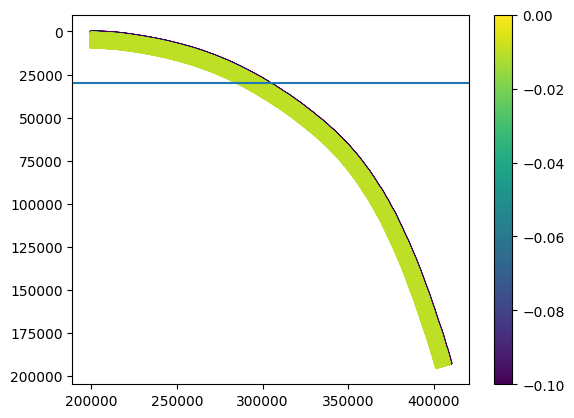

In [8]:
for i in range(len(ha_parallel_v_fx)):
    plt.scatter(parallel_slab_x[i], parallel_slab_y[i], c=ha_parallel_v_fy[i], s=1, vmin=-0.1, vmax=0.0)

plt.colorbar()
plt.axhline(30e3)
plt.gca().invert_yaxis()

# This now calculates the fluid velocity at each point within the slab using Darcy's Law. The only component left is to compute the change in porosity with depth within the slab.

Load in the depth porosity distribution from Bray & Karig 1985.

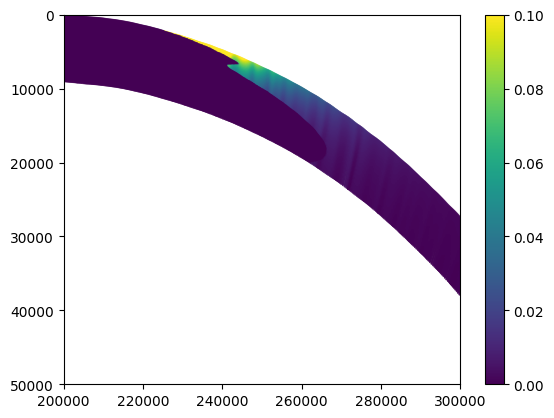

In [9]:
# Bray & Karig was not that easy to work with, use the empirical relationship from Chen et al., 2020
def chen_porosity_function(depth):
    if depth < 0:
        depth = 0
    m = 0.008
    phi_0 = 0.678
    # n = 89.53

    n = 5.989 
    m = 0.071 
    phi_0 = 0.474
    return phi_0 / (1 + m*depth)**n

# Initialize storage for tracking the porosity change downdip
# and also for the initial porosity input into the system. I 
# extracted the porosity of the material in the closest 20 km of the trench
# from Samer's data, which is output on a 50 m depth spacing. This means 
# that we can just use his data as is for the shallowest 9 km of the plate.
porosity_profile = np.loadtxt(fname="/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/CAM_outerrise/PUBLICATION_MODELS/data_files/trench_bin_porosity.txt")
porosity_inputs = porosity_profile[:, 1]
porosity_change = np.zeros(len(parallel_slab_x), dtype=object)

for i in range(len(porosity_change)):
    tracking_porosity = porosity_inputs[i]
    porosity_change[i] = np.zeros(len(parallel_slab_x[i]))
    for j in range(len(porosity_change[i])):
        depth_of_profile = parallel_slab_y[i][j] / 1e3 # km
        empirical_porosity = chen_porosity_function(depth_of_profile)
        if empirical_porosity < tracking_porosity:
            diff = tracking_porosity - empirical_porosity
            porosity_change[i][j] = tracking_porosity - empirical_porosity
        else:
            diff = 0
        tracking_porosity -= diff

for i in range(len(parallel_slab_x)):
    plt.scatter(parallel_slab_x[i], parallel_slab_y[i], c=porosity_change[i] * 100, vmin=0, vmax=0.1, s=0.1)
plt.colorbar()
plt.xlim(200e3, 300e3)
plt.ylim(0, 50e3)
plt.gca().invert_yaxis()

In [12]:
import importlib
import perplex_dehydration
importlib.reload(perplex_dehydration)

sediment_density    = 2300
MORB_density        = 2800
gabbro_density      = 3000
peridotite_density  = 3300

hydration_container = np.zeros(number_of_lines, dtype=object)
dehydration_container = np.zeros(number_of_lines, dtype=object)
hydration_container, dehydration_container = perplex_dehydration.perplex_dehydration(parallel_slab_p, parallel_slab_T, \
                                                              line_spacing, hydration_container, dehydration_container, \
                                                              P_mat, T_mat, \
                                                              sediment_thickness, sed_mat, sediment_density, \
                                                              MORB_thickness, nmo_mat, MORB_density, \
                                                              gabbro_thickness, gab_mat, gabbro_density, \
                                                              peridotite_thickness, per_mat, peridotite_density)

sediment_indices = np.empty(0, dtype=int)
MORB_indices = np.empty(0, dtype=int)
gabbro_indices = np.empty(0, dtype=int)
peridotite_indices = np.empty(0, dtype=int)

for i in range(number_of_lines):
    if i * line_spacing < sediment_thickness:
        sediment_indices = np.append(sediment_indices, i)
        
    elif i * line_spacing < sediment_thickness + MORB_thickness:
        MORB_indices = np.append(MORB_indices, i)
        
    elif i * line_spacing < sediment_thickness + MORB_thickness + gabbro_thickness:
        gabbro_indices = np.append(gabbro_indices, i)
        
    else:
        peridotite_indices = np.append(peridotite_indices, i)

sediment_dehydration   = dehydration_container[sediment_indices]
sediment_x             = parallel_slab_x[sediment_indices]
sediment_y             = parallel_slab_y[sediment_indices]

MORB_dehydration       = dehydration_container[MORB_indices]
MORB_x                 = parallel_slab_x[MORB_indices]
MORB_y                 = parallel_slab_y[MORB_indices]

gabbro_dehydration     = dehydration_container[gabbro_indices]
gabbro_x               = parallel_slab_x[gabbro_indices]
gabbro_y               = parallel_slab_y[gabbro_indices]

peridotite_dehydration = dehydration_container[peridotite_indices]
peridotite_x           = parallel_slab_x[peridotite_indices]
peridotite_y           = parallel_slab_y[peridotite_indices]

In [13]:
ha_porosity_surface_flux = perplex_dehydration.surface_flux_calculation(parallel_slab_arclengths, 
                                                                        ha_fluid_advection_in_solid, 
                                                                        porosity_change * 1030)

ha_no_lim_porosity_surface_flux = perplex_dehydration.surface_flux_calculation(parallel_slab_arclengths, 
                                                                               ha_no_lim_fluid_advection_in_solid, 
                                                                               porosity_change * 1030)

inf_porosity_surface_flux = perplex_dehydration.surface_flux_calculation(parallel_slab_arclengths, 
                                                                         inf_fluid_advection_in_solid, 
                                                                         porosity_change * 1030)

In [14]:
darc = 2.5e3
binned_arclength          = np.arange(np.min(parallel_slab_arclengths[0]), np.max(parallel_slab_arclengths[0]) + darc, darc)
binned_y_vals             = np.zeros(len(binned_arclength))
binned_porosity_ha        = np.zeros(len(binned_arclength))
binned_porosity_ha_no_lim = np.zeros(len(binned_arclength))
binned_porosity_inf       = np.zeros(len(binned_arclength))

# Convergence rate is in m/yr, dx and line spacing are in m
flux_convert = convergence_rate / (dx * line_spacing)
for i in range(len(binned_arclength) - 1):
    bin_index = np.where( (parallel_slab_arclengths[0] >= binned_arclength[i]) & (parallel_slab_arclengths[0] <= binned_arclength[i+1]) )
    binned_porosity_ha[i]        = np.trapz(ha_porosity_surface_flux[bin_index], dx=darc)
    binned_porosity_ha_no_lim[i] = np.trapz(ha_no_lim_porosity_surface_flux[bin_index], dx=darc)
    binned_porosity_inf[i]       = np.trapz(inf_porosity_surface_flux[bin_index], dx=darc)
    binned_y_vals[i]             = np.average(parallel_slab_y[0][bin_index])

In [17]:
# no_v_flux = (binned_porosity_no_v * flux_convert)[0: -1]
# v_flux = (binned_porosity * flux_convert)[0: -1]
v_flux_inf = (binned_porosity_inf * flux_convert)[0: -1]
v_flux_ha = (binned_porosity_ha * flux_convert)[0: -1]
v_flux_ha_no_lim = (binned_porosity_ha_no_lim * flux_convert)[0: -1]
scale_val = np.max(np.array([np.max(v_flux_inf), np.max(v_flux_ha), np.max(v_flux_ha_no_lim)]))

panel_width  = 12.0
panel_height = 8.0

panel_dim = [0, 0, panel_width, panel_height]

fig = plt.figure(dpi=100, figsize=(panel_width, panel_height))
main_ax = plt.axes(panel_dim)

for spine in main_ax.spines.values():
    spine.set_linewidth(15)

main_ax.plot(v_flux_inf / scale_val, binned_y_vals[0: -1] / 1e3, label="Immediate Removal", lw=100, c='#457B9D', ls='-')
main_ax.plot(v_flux_ha / scale_val, binned_y_vals[0: -1] / 1e3, label="Darcy's Flux with vel lim", lw=100, c='#E07A5F')
main_ax.plot(v_flux_ha_no_lim / scale_val, binned_y_vals[0: -1] / 1e3, label="Darcy's Flux", lw=100, c='black', ls=(0, (4, 1)))

main_ax.set_ylim(0, 50)
main_ax.set_xlim(-0.01, 1.1)
box = patches.Rectangle((-1, 53), 20, -18, linewidth=20,
                        edgecolor='black', facecolor='black', alpha=0.1)
main_ax.add_patch(box)

box = patches.Rectangle((-1, 53), 20, -18, linewidth=20,
                        edgecolor='black', facecolor='None', alpha=0.5)
main_ax.add_patch(box)

box = patches.Rectangle((-1, 5), 20, 15, linewidth=20,
                        edgecolor='black', facecolor='black', alpha=0.1)
main_ax.add_patch(box)

box = patches.Rectangle((-1, 5), 20, 15, linewidth=20,
                        edgecolor='black', facecolor='None', alpha=0.5)
main_ax.add_patch(box)

main_ax.invert_yaxis()
main_ax.set_ylabel("Depth - km", fontsize=250)
main_ax.set_xlabel("Normalized Pore Fluid Slab Surface Flux", fontsize=250)
main_ax.tick_params(axis="both", length=200, width=25, labelsize=250)

main_ax.legend(loc='center right', fontsize=250, bbox_to_anchor=(1, 0.45), handlelength=3)

main_ax.text(0.5, 17, "Depth of Inferred Fluid Release", fontsize=250)
main_ax.text(0.3, 43, "Depth of Inferred Fluid Release", fontsize=250)

# main_ax.text(-0.05, -4, "b)", fontsize=500)
plt.savefig("Figures/perm_flux.png", bbox_inches="tight")
plt.show()

In [18]:
100e6 / 9.81 / 3000 / 1e3

3.397893306150187